# 以 VGG16 為例，來示範 Transfer Learning 的作法

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, mean_proc='VGG16_ImageNet', img_size=224)

## 讀取 pretrain model 可選擇要不要使用它末端的 dense layers

* include_top = True，會沿用 pre-trained model 後端的全連接層
* include_top = False，只會留 pre-trained model 的 CNN 層

## Fine Tuning & Layer Transfer

* Fine tuning：不鎖 layers，pre-trained model 的每一層都可以再訓練
* Layer transfer：鎖住 pre-trained model 的 layers，只訓練自己額外加的 dense layers

實務上 fine tuning 跟 layer transfer 不會分這麼清楚，不一定會全鎖或全不鎖，你可能會留 CNN 的後面幾層是可以訓練的，但鎖住前面幾層做特徵萃取器。

# Fine Tuning 實例

In [3]:
# 此例完全不鎖層，充分的 fine tuning
model_name = 'VGG16-Fine-Tune'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,
                                            input_shape=(img_rows, img_cols, img_channel))
# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

58892288/58889256 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/TCNN0501.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/Variable_48/Assign = AssignVariableOp[_grappler_relax_allocator_constraints=true, dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/Variable_48, training/Adam/zeros_16)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/Adam/Variable_48/Assign', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/opt/conda/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-2a635a5dc77a>", line 23, in <module>
    callbacks = [checkpoint, earlystop])
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 1779, in fit_generator
    initial_epoch=initial_epoch)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_generator.py", line 204, in fit_generator
    x, y, sample_weight=sample_weight, class_weight=class_weight)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 1551, in train_on_batch
    self._make_train_function()
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 598, in _make_train_function
    params=self._collected_trainable_weights, loss=self.total_loss)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/optimizers.py", line 472, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/optimizers.py", line 472, in <listcomp>
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/backend.py", line 972, in zeros
    return variable(v, dtype=dtype, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/backend.py", line 648, in variable
    constraint=constraint)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 312, in __init__
    constraint=constraint)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 478, in _init_from_args
    name=n))
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_resource_variable_ops.py", line 157, in assign_variable_op
    "AssignVariableOp", resource=resource, value=value, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/Variable_48/Assign = AssignVariableOp[_grappler_relax_allocator_constraints=true, dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/Variable_48, training/Adam/zeros_16)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

In [ ]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet')

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/TCNN0501.csv'.format(model_name), index=False)

# Layer Transfer 實例

In [9]:
# 此例的 VGG pre-trained layers 完全鎖住，充分的 layer transfer
model_name = 'VGG16-Layer-Transfer'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = keras.applications.vgg16.VGG16(weights='imagenet',
                                            include_top=False, input_shape=(img_rows, img_cols, img_channel))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [10]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-5)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/100
69/70 [============================>.] - ETA: 0s - loss: 2.3714 - acc: 0.2367
Epoch 00001: val_loss improved from inf to 1.44165, saving model to ./saved_models/VGG16-Layer-Transfer.h5
70/70 [==============================] - 21s 301ms/step - loss: 2.3599 - acc: 0.2404 - val_loss: 1.4417 - val_acc: 0.6345
Epoch 2/100
69/70 [============================>.] - ETA: 0s - loss: 1.5685 - acc: 0.4746
Epoch 00002: val_loss improved from 1.44165 to 0.99773, saving model to ./saved_models/VGG16-Layer-Transfer.h5
70/70 [==============================] - 18s 254ms/step - loss: 1.5659 - acc: 0.4746 - val_loss: 0.9977 - val_acc: 0.7590
Epoch 3/100
69/70 [============================>.] - ETA: 0s - loss: 1.2332 - acc: 0.5979
Epoch 00003: val_loss improved from 0.99773 to 0.78836, saving model to ./saved_models/VGG16-Layer-Transfer.h5
70/70 [==============================] - 18s 262ms/step - loss: 1.2305 - acc: 0.5979 - val_loss: 0.7884 - val_acc: 0.8046
Epoch 4/100
69/70 [================

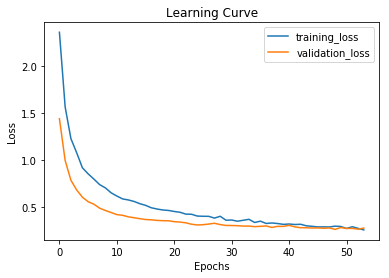

In [11]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

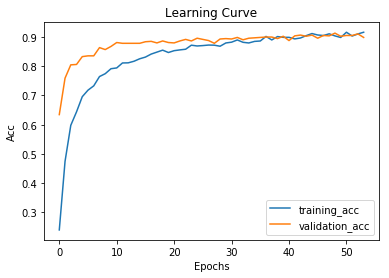

In [12]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [13]:
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

747/747 [==============================] - 2s 3ms/step
Validation loss: 0.2661104056251097
Validation accuracy: 0.9129852744310576


In [14]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet')

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)